In [1]:
from src.clean_data import get_cleaned_data

df = get_cleaned_data()
df

cleaning data...
removing 16 rows with price >= 150000...
removing 25 rows with invalid district...
final length: 397


,url,last_update,price,district,bag_of_words,neubau,area,rooms,needs_fix,leased
0,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-02 12:18:00,119500.0,1160,4 wohneinheiten einzeln oder im paket - nähe l...,False,30.81,1.0,None,False
1,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-05 16:10:00,149000.0,1210,do it yourself-rohdiamant!diese immobilie wird...,False,52.70,2.0,True,None
2,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-06 07:24:00,129000.0,1160,leistbares wohnen in schöner lage - charmanter...,False,32.95,1.0,False,False
3,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-04 10:27:00,133250.0,1100,eckert 19 - charmante wohnungen - im herzen de...,False,41.01,2.0,False,None
4,https://www.willhaben.at/iad/immobilien/d/eige...,2024-03-28 11:30:00,149000.0,1160,nach generalsanierung! 1-zimmerwohnung in 1160...,False,34.10,1.0,False,None
...,...,...,...,...,...,...,...,...,...,...
431,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-02 10:00:00,149000.0,1150,++hofseitig++1-zimmer altbauwohnung mit garten...,False,33.79,1.0,True,None
434,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-03 11:18:00,99000.0,1170,einzigartige gelegenheit in top lage dornbachs...,None,23.43,1.0,None,None
435,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-04 10:56:00,119800.0,1140,kleines apartment in hütteldorfkleines sanieru...,False,30.42,NaN,True,None
436,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-04 15:55:00,112000.0,1160,singlewohnung in wien - unweit s-bahn hernals ...,False,28.08,1.0,None,False


# choose best

In [12]:
import webbrowser

dfcpy = df.copy()

# ---------------- eliminating deal breakers

prev_len = len(dfcpy)
dfcpy = dfcpy[dfcpy['needs_fix'] != True]
print(f"removed {prev_len - len(dfcpy)}: needs_fix flag")

prev_len = len(dfcpy)
dfcpy = dfcpy[dfcpy['leased'] != True]
print(f"removed {prev_len - len(dfcpy)}: leased flag")

bad_words = [
    "unbefristet",
    "vermietet",
    "renovierung",
    "sanierung",
]
prev_len = len(dfcpy)
for word in bad_words:
    dfcpy = dfcpy[~dfcpy['bag_of_words'].str.contains(word, case=False)]
print(f"removed {prev_len - len(dfcpy)}: contained bad words")

# ---------------- optional filters

# prev_len = len(dfcpy)
# dfcpy = dfcpy[dfcpy['neubau'] == True]
# print(f"removed {prev_len - len(dfcpy)}: not neubau")

print("final:", len(dfcpy))

# ---------------- open in browser

dfcpy = dfcpy.sort_values(by='price', ascending=True) # type: ignore
urls = dfcpy['url'].tolist()
counter = 0
for url in urls:
    print(f"progress {counter/len(urls)*100:.2f}%", end="\r")
    webbrowser.open(url)
    counter += 1


removed 99: needs_fix flag
removed 10: leased flag
removed 170: contained bad words
final: 118


KeyboardInterrupt: 

# explore data

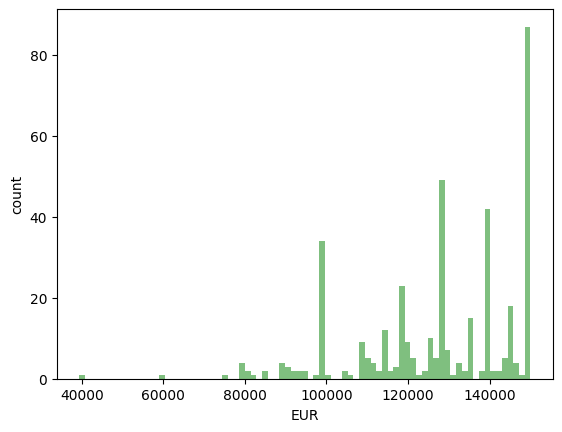

In [3]:
# price distribution

import matplotlib.pyplot as plt

plt.hist(df["price"], bins=len(df) // 5, color="green", alpha=0.5) 
plt.xlabel("EUR")
plt.ylabel("count")
plt.show()

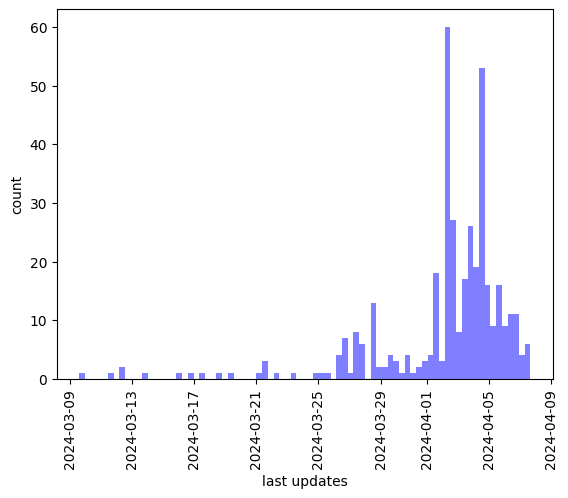

In [4]:
# update distribution

plt.hist(df["last_update"], bins=len(df) // 5, color="blue", alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("count")
plt.xlabel("last updates")
plt.show()

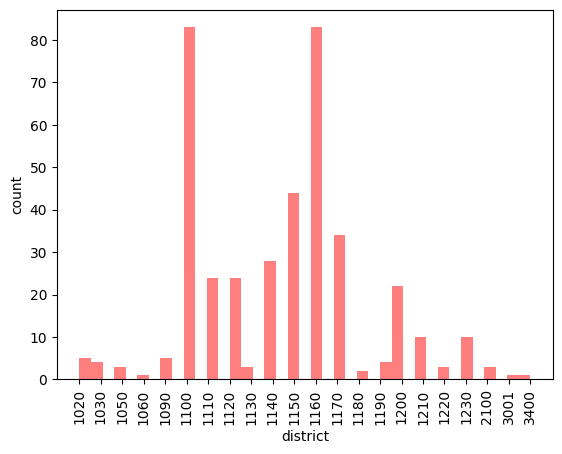

In [5]:
# district distribution

plt.hist(df.sort_values(by="district")["district"], bins=len(df) // 10, color="red", alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("count")
plt.xlabel("district")
plt.show()

In [6]:
# needs_fix distribution

print(f"needs fix: {len(df[df['needs_fix'] == True]) / len(df) * 100:.2f}%")

needs fix: 24.94%


In [7]:
# room distribution

df_cpy = df.copy()
df_cpy["rooms"] = df_cpy["rooms"].apply(lambda x: x if x < 10 else 1)
print(df_cpy["rooms"].value_counts())

rooms
1.0    300
2.0     95
3.0      2
Name: count, dtype: int64
